In [1]:
# Importing Library 
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing data
alnz = pd.read_csv('data/allianz.csv')
depost = pd.read_csv('data/deutsche-post.csv')
detel = pd.read_csv('data/deutsche-telekom.csv')
merckg = pd.read_csv('data/merck-kgaa.csv')
siem = pd.read_csv('data/siemens.csv')

In [3]:
#Drop unnecessary data
alnz.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
depost.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
detel.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
merckg.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
siem.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)

In [4]:
# Change Dtype of Date column
alnz['Date']=pd.to_datetime(alnz['Date'])
depost['Date']=pd.to_datetime(depost['Date'])
detel['Date']=pd.to_datetime(detel['Date'])
merckg['Date']=pd.to_datetime(merckg['Date'])
siem['Date']=pd.to_datetime(siem['Date'])

In [5]:
#Set Index as Date
alnz.set_index('Date',inplace=True)
depost.set_index('Date',inplace=True)
detel.set_index('Date',inplace=True)
merckg.set_index('Date',inplace=True)
siem.set_index('Date',inplace=True)

In [6]:
# Backup data
siem_base = siem.copy()
detel_base = detel.copy()
alnz_base = alnz.copy()
merckg_base = merckg.copy()
depost_base = depost.copy()

# Allianz 1 Features

In [7]:
#Set next day value as target 
alnz['Target'] = alnz.Close.shift(-1)
alnz.dropna(inplace=True)
alnz

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,45.519119,9.154412,1.292624,45.657921
2010-01-05,45.657921,9.154412,1.292624,46.012665
2010-01-06,46.012665,9.154412,1.292624,45.483131
2010-01-07,45.483131,9.154412,1.292624,45.236355
2010-01-08,45.236355,9.154412,1.292624,44.727394
...,...,...,...,...
2023-06-23,209.149994,10.264393,1.461468,209.199997
2023-06-26,209.199997,10.264393,1.461468,211.300003
2023-06-27,211.300003,10.264393,1.461468,211.649994


In [8]:
# Set date variable
start_date = '2010-01-04' # Start date of training set
end_date = '2020-10-07' # End date of training set
test_start_date = '2020-10-08' # End date of test set
test_end_date = '2023-06-30' # End date of test set

In [9]:
#split train and test data
alnz_train = alnz.loc[:end_date]
alnz_test = alnz.loc[test_start_date:]

In [10]:
# Reconcile length of data set and subsets
alnz.shape[0] == alnz_train.shape[0] + alnz_test.shape[0]

True

In [11]:
#set features and target
alnz_X_train = alnz_train['Close']
alnz_y_train = alnz_train['Target']
alnz_X_test = alnz_test['Close']
alnz_y_test = alnz_test['Target']

In [12]:
#set variables for regression
alnz_X_train = np.array(alnz_train['Close']).reshape(-1, 1)
alnz_y_train = np.array(alnz_train['Target']).reshape(-1, 1)
alnz_X_test = np.array(alnz_test['Close']).reshape(-1, 1)
alnz_y_test = np.array(alnz_test['Target']).reshape(-1, 1)

# Model

In [13]:
#set parameters
parameters = {
    'n_estimators': [10, 20, 50, 100, 200, 300],
    'max_depth': [None, 2, 4, 6, 8, 10, 20],
    'min_samples_split': [2, 3, 4, 5, 6, 8, 16, 32, 64],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

In [14]:
# Setting up RandomizedSearchCV
model1 = RandomForestRegressor()
random_search1 = RandomizedSearchCV(estimator=model1,
                                    param_distributions=parameters,
                                    n_iter=50,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    random_state=42)

In [15]:
random_search1.fit(alnz_X_train, alnz_y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   param_distributions={'max_depth': [None, 2, 4, 6, 8, 10, 20],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 3, 4, 5, 6, 8,
                                                              16, 32, 64],
                                        'n_estimators': [10, 20, 50, 100, 200,
                                                         300]},
                   random_state=42, scoring='neg_mean_squared_error')

In [16]:
print(f'Best params: {random_search1.best_params_}')
print(f'Best validation score = {random_search1.best_score_}')

Best params: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': None}
Best validation score = -41.31994389624666


In [17]:
#fit the model
model1 = RandomForestRegressor(**random_search1.best_params_)
model1.fit(alnz_X_train, alnz_y_train)

RandomForestRegressor(min_samples_leaf=2, min_samples_split=4, n_estimators=200)

In [18]:
#predicted data 
alnz_test['Predicted_Close'] = model1.predict(alnz_X_test)

In [19]:
#show the result
alnz_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,144.441971,9.953418,0.874770,144.838226,144.489438
2020-10-09,144.838226,9.953418,0.874770,146.302643,145.887981
2020-10-12,146.302643,9.953418,0.874770,143.442734,145.194028
2020-10-13,143.442734,9.953418,0.874770,143.873459,144.281600
2020-10-14,143.873459,9.953418,0.874770,139.755890,144.182626
...,...,...,...,...,...
2023-06-23,209.149994,10.264393,1.461468,209.199997,186.687020
2023-06-26,209.199997,10.264393,1.461468,211.300003,186.687020
2023-06-27,211.300003,10.264393,1.461468,211.649994,186.687020


In [20]:
#agin return to previous shape
alnz_y_test = np.array(alnz_test['Target'])

In [21]:
#checking mse and rmse 
alnz_mse = mean_squared_error(alnz_y_test, alnz_test['Predicted_Close'])
alnz_rmse = math.sqrt(alnz_mse)
alnz_mape = np.mean(np.abs(alnz_test['Predicted_Close'] - alnz_y_test)/np.abs(alnz_y_test))

print(f'Root Mean Squared Error (RMSE): {alnz_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {alnz_mape}')

Root Mean Squared Error (RMSE): 10.23882677070614
Mean Absolute Percentage Error (MAPE): 0.03434755731873018


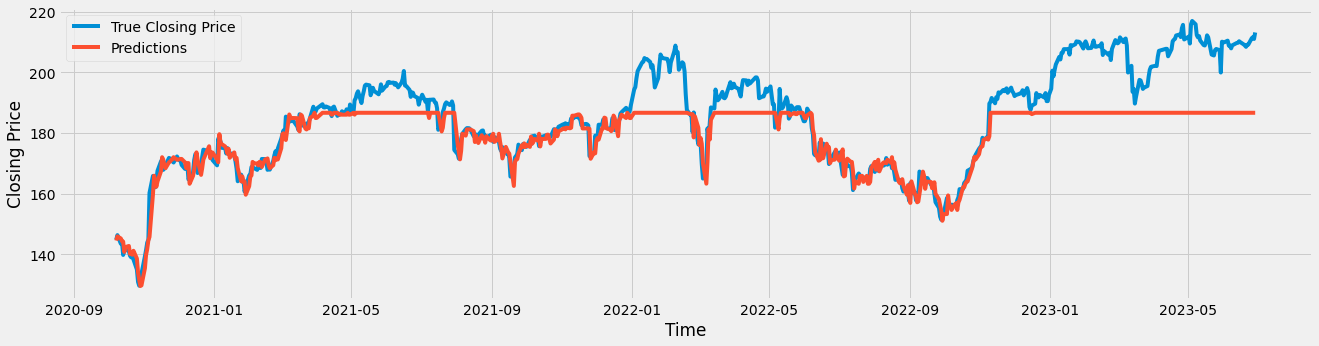

In [22]:
#shwing predicted data
plt.figure(figsize=(20, 5))
plt.plot(alnz_test['Target'], label = 'True Closing Price')
plt.plot(alnz_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [23]:
# Create a dataframe that has same index as allianz dataframe
result1 = pd.DataFrame(index=alnz_base.index)
# Extract actual data from SIE
tem1 = alnz_base['Close'].tolist()[:len(alnz_base)-695]
# Extract forecasted date from above result
tem2 = alnz_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['ALV'] = tem3
# Mark forecasted or not for each line
result1['Forecasted'] = 'N'
result1.loc[result1.index[-695:], 'Forecasted'] = 'Y'

In [24]:
result1

,ALV,Forecasted
Date,,
2010-01-04,45.519119,N
2010-01-05,45.657921,N
2010-01-06,46.012665,N
2010-01-07,45.483131,N
2010-01-08,45.236355,N
...,...,...
2023-06-26,186.687020,Y
2023-06-27,186.687020,Y
2023-06-28,186.687020,Y


# Deutsche Post 1 Features

In [25]:
#Set next day value as target 
depost['Target'] = depost.Close.shift(-1)
depost.dropna(inplace=True)
depost

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,13.980000,25.443396,1.970697,14.000
2010-01-05,14.000000,25.443396,1.970697,14.155
2010-01-06,14.155000,25.443396,1.970697,14.125
2010-01-07,14.125000,25.443396,1.970697,14.460
2010-01-08,14.460000,25.443396,1.970697,14.380
...,...,...,...,...
2023-06-23,43.189999,10.613300,1.588590,43.000
2023-06-26,43.000000,10.613300,1.588590,43.500
2023-06-27,43.500000,10.613300,1.588590,44.305


In [26]:
#split train and test data
depost_train = depost.loc[:end_date]
depost_test = depost.loc[test_start_date:]

In [27]:
# Reconcile length of data set and subsets
depost.shape[0] == depost_train.shape[0] + depost_test.shape[0]

True

In [28]:
#set features and target
depost_X_train = depost_train['Close']
depost_y_train = depost_train['Target']
depost_X_test = depost_test['Close']
depost_y_test = depost_test['Target']

In [29]:
#set variables for regression
depost_X_train = np.array(depost_train['Close']).reshape(-1, 1)
depost_y_train = np.array(depost_train['Target']).reshape(-1, 1)
depost_X_test = np.array(depost_test['Close']).reshape(-1, 1)
depost_y_test = np.array(depost_test['Target']).reshape(-1, 1)

In [30]:
# Setting up RandomizedSearchCV
model2 = RandomForestRegressor()
random_search2 = RandomizedSearchCV(estimator=model2,
                                    param_distributions=parameters,
                                    n_iter=50,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    random_state=42)
random_search2.fit(depost_X_train, depost_y_train)
print(f'Best params: {random_search2.best_params_}')
print(f'Best validation score = {random_search2.best_score_}')

Best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_depth': 8}
Best validation score = -0.6407388226774897


In [31]:
#fit the model
model2 = RandomForestRegressor(**random_search2.best_params_)
model2.fit(depost_X_train, depost_y_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=8, n_estimators=300)

In [32]:
#predicted data 
depost_test['Predicted_Close'] = model2.predict(depost_X_test)

In [33]:
#agin return to previous shape
depost_y_test = np.array(depost_test['Target'])

In [34]:
#checking mse and rmse 
depost_mse = mean_squared_error(depost_y_test, depost_test['Predicted_Close'])
depost_rmse = math.sqrt(depost_mse)
depost_mape = np.mean(np.abs(depost_test['Predicted_Close'] - depost_y_test)/np.abs(depost_y_test))

print(f'Root Mean Squared Error (RMSE): {depost_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {depost_mape}')

Root Mean Squared Error (RMSE): 8.534022102751164
Mean Absolute Percentage Error (MAPE): 0.10438417525627187


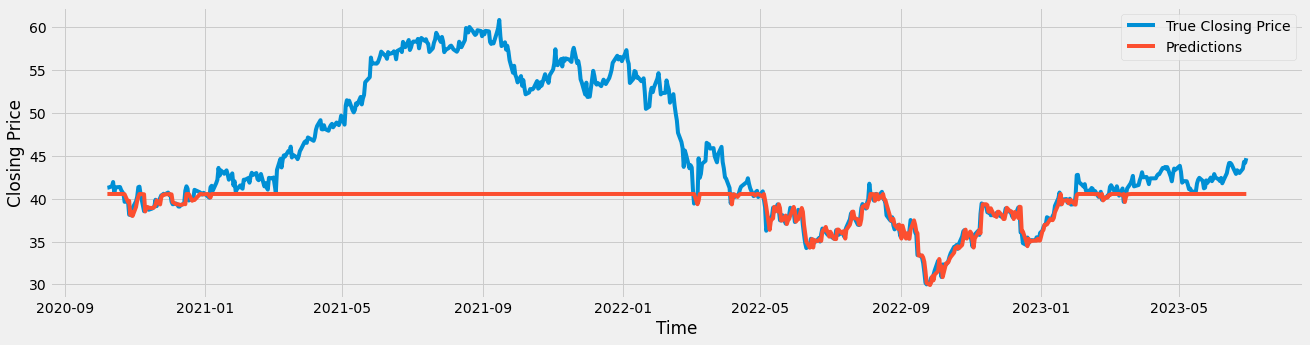

In [35]:
#shwing predicted data
plt.figure(figsize=(20, 5))
plt.plot(depost_test['Target'], label = 'True Closing Price')
plt.plot(depost_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [36]:
#checking predicted data
depost_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,40.970001,18.933283,3.600308,41.279999,40.554138
2020-10-09,41.279999,18.933283,3.600308,41.299999,40.554138
2020-10-12,41.299999,18.933283,3.600308,41.470001,40.554138
2020-10-13,41.470001,18.933283,3.600308,41.950001,40.554138
2020-10-14,41.950001,18.933283,3.600308,40.709999,40.554138
...,...,...,...,...,...
2023-06-23,43.189999,10.613300,1.588590,43.000000,40.554138
2023-06-26,43.000000,10.613300,1.588590,43.500000,40.554138
2023-06-27,43.500000,10.613300,1.588590,44.305000,40.554138


In [37]:
# Extract actual data from depost
tem1 = depost_base['Close'].tolist()[:len(depost_base)+6-695]
# Extract forecasted date from above result
tem2 = depost_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DHL'] = tem3

In [38]:
#added predicted data with real data
result1

,ALV,Forecasted,DHL
Date,,,
2010-01-04,45.519119,N,13.980000
2010-01-05,45.657921,N,14.000000
2010-01-06,46.012665,N,14.155000
2010-01-07,45.483131,N,14.125000
2010-01-08,45.236355,N,14.460000
...,...,...,...
2023-06-26,186.687020,Y,40.554138
2023-06-27,186.687020,Y,40.554138
2023-06-28,186.687020,Y,40.554138


# Deutsche Telekom 1 Features

In [39]:
#Set next day value as target 
detel['Target'] = detel.Close.shift(-1)
detel.dropna(inplace=True)
detel

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,4.953136,128.625000,1.070129,4.911083
2010-01-05,4.911083,128.625000,1.070129,4.789590
2010-01-06,4.789590,128.625000,1.070129,4.698472
2010-01-07,4.698472,128.625000,1.070129,4.724171
2010-01-08,4.724171,128.625000,1.070129,4.756881
...,...,...,...,...
2023-06-23,19.558001,5.658228,1.057418,19.695999
2023-06-26,19.695999,5.658228,1.057418,19.906000
2023-06-27,19.906000,5.658228,1.057418,20.030001


In [40]:
#split train and test data
detel_train = detel.loc[:end_date]
detel_test = detel.loc[test_start_date:]

In [41]:
# Reconcile length of data set and subsets
detel.shape[0] == detel_train.shape[0] + detel_test.shape[0]

True

In [42]:
#set features and target
detel_X_train = detel_train['Close']
detel_y_train = detel_train['Target']
detel_X_test = detel_test['Close']
detel_y_test = detel_test['Target']

In [43]:
#set variables for regression
detel_X_train = np.array(detel_train['Close']).reshape(-1, 1)
detel_y_train = np.array(detel_train['Target']).reshape(-1, 1)
detel_X_test = np.array(detel_test['Close']).reshape(-1, 1)
detel_y_test = np.array(detel_test['Target']).reshape(-1, 1)

In [44]:
# Setting up RandomizedSearchCV
model3 = RandomForestRegressor()
random_search3 = RandomizedSearchCV(estimator=model3,
                                    param_distributions=parameters,
                                    n_iter=50,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    random_state=42)
random_search3.fit(detel_X_train, detel_y_train)
print(f'Best params: {random_search3.best_params_}')
print(f'Best validation score = {random_search3.best_score_}')

Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 6}
Best validation score = -0.03384427146096419


In [45]:
#fit the model
model3 = RandomForestRegressor(**random_search3.best_params_)
model3.fit(detel_X_train, detel_y_train)

RandomForestRegressor(max_depth=6, min_samples_split=5, n_estimators=200)

In [46]:
#predicted data 
detel_test['Predicted_Close'] = model3.predict(detel_X_test)

In [47]:
#showing predicted data
detel_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,13.030954,21.651515,0.940896,12.981357,13.058188
2020-10-09,12.981357,21.651515,0.940896,13.067026,12.887242
2020-10-12,13.067026,21.651515,0.940896,13.107607,13.121065
2020-10-13,13.107607,21.651515,0.940896,13.053500,13.164107
2020-10-14,13.053500,21.651515,0.940896,12.643183,13.093444
...,...,...,...,...,...
2023-06-23,19.558001,5.658228,1.057418,19.695999,13.784796
2023-06-26,19.695999,5.658228,1.057418,19.906000,13.784796
2023-06-27,19.906000,5.658228,1.057418,20.030001,13.784796


In [48]:
#agin return to previous shape
detel_y_test = np.array(detel_test['Target'])

In [49]:
#checking mse and rmse 
detel_mse = mean_squared_error(detel_y_test, detel_test['Predicted_Close'])
detel_rmse = math.sqrt(detel_mse)
detel_mape = np.mean(np.abs(detel_test['Predicted_Close'] - detel_y_test)/np.abs(detel_y_test))

print(f'Root Mean Squared Error (RMSE): {detel_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {detel_mape}')

Root Mean Squared Error (RMSE): 3.894847810460541
Mean Absolute Percentage Error (MAPE): 0.17287477982063804


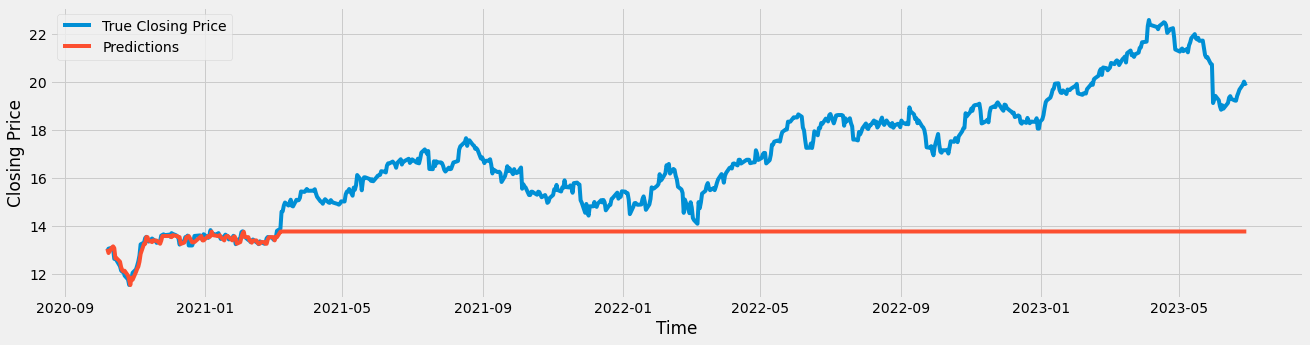

In [50]:
#shwing predicted data
plt.figure(figsize=(20, 5))
plt.plot(detel_test['Target'], label = 'True Closing Price')
plt.plot(detel_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [51]:
# Extract actual data from deutsche-telekom
tem1 = detel_base['Close'].tolist()[:len(detel_base)-695]
# Extract forecasted date from above result
tem2 = detel_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DTE'] = tem3

In [52]:
#added predicted data with real data
result1

,ALV,Forecasted,DHL,DTE
Date,,,,
2010-01-04,45.519119,N,13.980000,4.953136
2010-01-05,45.657921,N,14.000000,4.911083
2010-01-06,46.012665,N,14.155000,4.789590
2010-01-07,45.483131,N,14.125000,4.698472
2010-01-08,45.236355,N,14.460000,4.724171
...,...,...,...,...
2023-06-26,186.687020,Y,40.554138,13.784796
2023-06-27,186.687020,Y,40.554138,13.784796
2023-06-28,186.687020,Y,40.554138,13.784796


# Merck KGaA 1 Features

In [53]:
#Set next day value as target 
merckg['Target'] = merckg.Close.shift(-1)
merckg.dropna(inplace=True)
merckg

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,26.576839,38.785717,1.488928,26.381214
2010-01-05,26.381214,38.785717,1.488928,26.364910
2010-01-06,26.364910,38.785717,1.488928,26.919188
2010-01-07,26.919188,38.785717,1.488928,26.646120
2010-01-08,26.646120,38.785717,1.488928,26.739857
...,...,...,...,...
2023-06-23,152.949997,23.026846,3.013593,152.600006
2023-06-26,152.600006,23.026846,3.013593,147.199997
2023-06-27,147.199997,23.026846,3.013593,150.500000


In [54]:
#split train and test data
merckg_train = merckg.loc[:end_date]
merckg_test = merckg.loc[test_start_date:]

In [55]:
# Reconcile length of data set and subsets
merckg.shape[0] == merckg_train.shape[0] + merckg_test.shape[0]

True

In [56]:
#set features and target
merckg_X_train = merckg_train['Close']
merckg_y_train = merckg_train['Target']
merckg_X_test = merckg_test['Close']
merckg_y_test = merckg_test['Target']

In [57]:
#set variables for regression
merckg_X_train = np.array(merckg_train['Close']).reshape(-1, 1)
merckg_y_train = np.array(merckg_train['Target']).reshape(-1, 1)
merckg_X_test = np.array(merckg_test['Close']).reshape(-1, 1)
merckg_y_test = np.array(merckg_test['Target']).reshape(-1, 1)

In [58]:
# Setting up RandomizedSearchCV
model4 = RandomForestRegressor()
random_search4 = RandomizedSearchCV(estimator=model4,
                                    param_distributions=parameters,
                                    n_iter=50,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    random_state=42)
random_search4.fit(merckg_X_train, merckg_y_train)
print(f'Best params: {random_search4.best_params_}')
print(f'Best validation score = {random_search4.best_score_}')

Best params: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': None}
Best validation score = -14.20478785162037


In [59]:
#fit the model
model4 = RandomForestRegressor(**random_search4.best_params_)
model4.fit(merckg_X_train, merckg_y_train)

RandomForestRegressor(min_samples_leaf=2, min_samples_split=4, n_estimators=200)

In [60]:
#predicted data 
merckg_test['Predicted_Close'] = model4.predict(merckg_X_test)

In [61]:
merckg_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,126.032745,28.965117,3.009257,126.661209,124.421818
2020-10-09,126.661209,28.965117,3.009257,126.661209,124.421818
2020-10-12,126.661209,28.965117,3.009257,126.226120,124.421818
2020-10-13,126.226120,28.965117,3.009257,124.098984,124.421818
2020-10-14,124.098984,28.965117,3.009257,119.699684,124.341635
...,...,...,...,...,...
2023-06-23,152.949997,23.026846,3.013593,152.600006,124.421818
2023-06-26,152.600006,23.026846,3.013593,147.199997,124.421818
2023-06-27,147.199997,23.026846,3.013593,150.500000,124.421818


In [62]:
#agin return to previous shape
merckg_y_test = np.array(merckg_test['Target'])

In [63]:
#checking mse and rmse 
merckg_mse = mean_squared_error(merckg_y_test, merckg_test['Predicted_Close'])
merckg_rmse = math.sqrt(merckg_mse)
merckg_mape = np.mean(np.abs(merckg_test['Predicted_Close'] - merckg_y_test)/np.abs(merckg_y_test))

print(f'Root Mean Squared Error (RMSE): {merckg_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {merckg_mape}')

Root Mean Squared Error (RMSE): 48.866832223781
Mean Absolute Percentage Error (MAPE): 0.24151571203902905


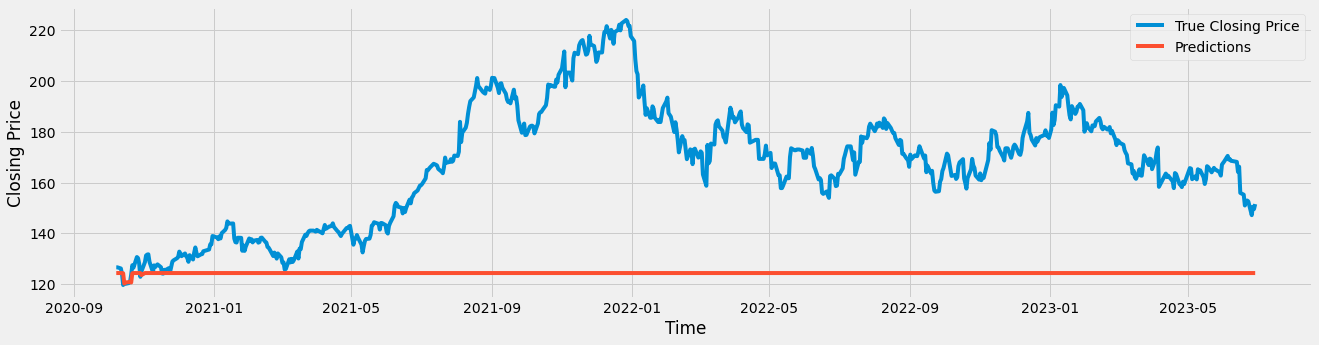

In [64]:
#plotting predicted data
plt.figure(figsize=(20, 5))
plt.plot(merckg_test['Target'], label = 'True Closing Price')
plt.plot(merckg_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [65]:
# Extract actual data from merck-kgaa
tem1 = merckg_base['Close'].tolist()[:len(merckg_base)-695]
# Extract forecasted date from above result
tem2 = merckg_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['MRK'] = tem3

In [66]:
#added predicted data with real data
result1

,ALV,Forecasted,DHL,DTE,MRK
Date,,,,,
2010-01-04,45.519119,N,13.980000,4.953136,26.576839
2010-01-05,45.657921,N,14.000000,4.911083,26.381214
2010-01-06,46.012665,N,14.155000,4.789590,26.364910
2010-01-07,45.483131,N,14.125000,4.698472,26.919188
2010-01-08,45.236355,N,14.460000,4.724171,26.646120
...,...,...,...,...,...
2023-06-26,186.687020,Y,40.554138,13.784796,124.421818
2023-06-27,186.687020,Y,40.554138,13.784796,124.421818
2023-06-28,186.687020,Y,40.554138,13.784796,124.421818


# Siemens 1 Features

In [67]:
#Set next day value as target 
siem['Target'] = siem.Close.shift(-1)
siem.dropna(inplace=True)
siem

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,39.892437,21.092000,1.938798,39.916805
2010-01-05,39.916805,21.092000,1.938798,40.063042
2010-01-06,40.063042,21.092000,1.938798,40.538315
2010-01-07,40.538315,21.092000,1.938798,40.794235
2010-01-08,40.794235,21.092000,1.938798,40.897816
...,...,...,...,...
2023-06-23,156.979996,19.691292,1.998793,155.479996
2023-06-26,155.479996,19.691292,1.998793,157.559998
2023-06-27,157.559998,19.691292,1.998793,152.720001


In [68]:
#split train and test data
siem_train = siem.loc[:end_date]
siem_test = siem.loc[test_start_date:]

In [69]:
# Reconcile length of data set and subsets
siem.shape[0] == siem_train.shape[0] + siem_test.shape[0]

True

In [70]:
#set features and target
siem_X_train = siem_train['Close']
siem_y_train = siem_train['Target']
siem_X_test = siem_test['Close']
siem_y_test = siem_test['Target']

In [71]:
len(siem_X_test)

695

In [72]:
#set variables for regression
siem_X_train = np.array(siem_train['Close']).reshape(-1, 1)
siem_y_train = np.array(siem_train['Target']).reshape(-1, 1)
siem_X_test = np.array(siem_test['Close']).reshape(-1, 1)
siem_y_test = np.array(siem_test['Target']).reshape(-1, 1)

In [73]:
# Setting up RandomizedSearchCV
model5 = RandomForestRegressor()
random_search5 = RandomizedSearchCV(estimator=model5,
                                    param_distributions=parameters,
                                    n_iter=50,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    random_state=42)
random_search5.fit(siem_X_train, siem_y_train)
print(f'Best params: {random_search5.best_params_}')
print(f'Best validation score = {random_search5.best_score_}')

Best params: {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_depth': 6}
Best validation score = -1.5339315633261417


In [74]:
#fit the model
model5 = RandomForestRegressor(**random_search5.best_params_)
model5.fit(siem_X_train, siem_y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=6, min_samples_split=4,
                      n_estimators=50)

In [75]:
#predicted data 
siem_test['Predicted_Close'] = model5.predict(siem_X_test)

In [76]:
#checking predicted data
siem_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,102.015335,21.575999,2.165320,102.678017,101.696374
2020-10-09,102.678017,21.575999,2.165320,103.487961,102.880375
2020-10-12,103.487961,21.575999,2.165320,102.383484,103.564127
2020-10-13,102.383484,21.575999,2.165320,103.451141,101.800533
2020-10-14,103.451141,21.575999,2.165320,100.634758,103.472087
...,...,...,...,...,...
2023-06-23,156.979996,19.691292,1.998793,155.479996,109.214657
2023-06-26,155.479996,19.691292,1.998793,157.559998,109.214657
2023-06-27,157.559998,19.691292,1.998793,152.720001,109.214657


In [77]:
#agin return to previous shape
siem_y_test = np.array(siem_test['Target'])

In [78]:
#added predicted data with real data
siem_mse = mean_squared_error(siem_y_test, siem_test['Predicted_Close'])
siem_rmse = math.sqrt(siem_mse)
siem_mape = np.mean(np.abs(siem_test['Predicted_Close'] - siem_y_test)/np.abs(siem_y_test))

print(f'Root Mean Squared Error (RMSE): {siem_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {siem_mape}')

Root Mean Squared Error (RMSE): 22.839857087049232
Mean Absolute Percentage Error (MAPE): 0.13306384749216757


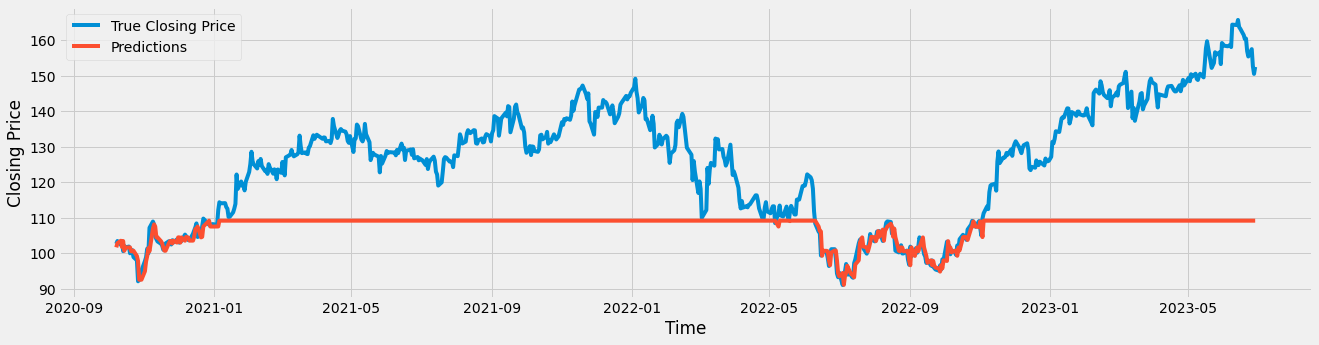

In [79]:
#plotting predicted data
plt.figure(figsize=(20, 5))
plt.plot(siem_test['Target'], label = 'True Closing Price')
plt.plot(siem_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [80]:
# Extract actual data from siem
tem1 = siem_base['Close'].tolist()[:len(siem_base)-695]
# Extract forecasted date from above result
tem2 = siem_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['SIE'] = tem3

In [81]:
#merged all predicted data
result1

,ALV,Forecasted,DHL,DTE,MRK,SIE
Date,,,,,,
2010-01-04,45.519119,N,13.980000,4.953136,26.576839,39.892437
2010-01-05,45.657921,N,14.000000,4.911083,26.381214,39.916805
2010-01-06,46.012665,N,14.155000,4.789590,26.364910,40.063042
2010-01-07,45.483131,N,14.125000,4.698472,26.919188,40.538315
2010-01-08,45.236355,N,14.460000,4.724171,26.646120,40.794235
...,...,...,...,...,...,...
2023-06-26,186.687020,Y,40.554138,13.784796,124.421818,109.214657
2023-06-27,186.687020,Y,40.554138,13.784796,124.421818,109.214657
2023-06-28,186.687020,Y,40.554138,13.784796,124.421818,109.214657


In [82]:
# Define the desired column order
desired_order = ['SIE', 'DTE', 'ALV', 'MRK', 'DHL', 'Forecasted']

# Rearrange columns
result = result1[desired_order]
result

,SIE,DTE,ALV,MRK,DHL,Forecasted
Date,,,,,,
2010-01-04,39.892437,4.953136,45.519119,26.576839,13.980000,N
2010-01-05,39.916805,4.911083,45.657921,26.381214,14.000000,N
2010-01-06,40.063042,4.789590,46.012665,26.364910,14.155000,N
2010-01-07,40.538315,4.698472,45.483131,26.919188,14.125000,N
2010-01-08,40.794235,4.724171,45.236355,26.646120,14.460000,N
...,...,...,...,...,...,...
2023-06-26,109.214657,13.784796,186.687020,124.421818,40.554138,Y
2023-06-27,109.214657,13.784796,186.687020,124.421818,40.554138,Y
2023-06-28,109.214657,13.784796,186.687020,124.421818,40.554138,Y


In [83]:
#checking the final data
result

,SIE,DTE,ALV,MRK,DHL,Forecasted
Date,,,,,,
2010-01-04,39.892437,4.953136,45.519119,26.576839,13.980000,N
2010-01-05,39.916805,4.911083,45.657921,26.381214,14.000000,N
2010-01-06,40.063042,4.789590,46.012665,26.364910,14.155000,N
2010-01-07,40.538315,4.698472,45.483131,26.919188,14.125000,N
2010-01-08,40.794235,4.724171,45.236355,26.646120,14.460000,N
...,...,...,...,...,...,...
2023-06-26,109.214657,13.784796,186.687020,124.421818,40.554138,Y
2023-06-27,109.214657,13.784796,186.687020,124.421818,40.554138,Y
2023-06-28,109.214657,13.784796,186.687020,124.421818,40.554138,Y


In [84]:
#save forecased data in csv file
result.to_csv('RandomForest_1 feature.csv', index=True)

# Bibliography

-	Jose, L. (2023). _Stock_Prediction_Using_RandomForestRegressor/Machine_Learning_Stock_Prediction_Using_Random_Forest_Regressor.ipynb at main · no37no37/Stock_Prediction_Using_RandomForestRegressor._ [online] GitHub. Available at: https://github.com/no37no37/Stock_Prediction_Using_RandomForestRegressor/blob/main/Machine_Learning_Stock_Prediction_Using_Random_Forest_Regressor.ipynb [Accessed 26 Feb. 2024].
-	manilalam (2024). _Stock-market-Turnover-prediction-using-RandomForestRegressor/Stock_market turnover prediction.ipynb at main · manilalam/Stock-market-Turnover-prediction-using-RandomForestRegressor._ [online] GitHub. Available at: https://github.com/manilalam/Stock-market-Turnover-prediction-using-RandomForestRegressor/blob/main/Stock_market%20turnover%20prediction.ipynb [Accessed 26 Feb. 2024].